In [7]:
import csv
import cv2
import numpy as np
import sklearn
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
import math
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [27]:
samples = []

csv_path = ['data/data/driving_log.csv', 'data/ds1/driving_log.csv']

for j in range(2):
    if j==2:
        # 0 = my own data, 1 = Udacity supplied data , any other no = use both dataset
        print('not using dataset ', j)
        continue
    with open(csv_path[j]) as csvfile:
        #csvlines = csvfile.readlines()  # if we use this method then comment below 3 lines and replace samples by csvlines
        reader = csv.reader(csvfile)
        for line in reader:
             # skip it if ~0 speed - not representative of driving behavior
            if float(line[6]) < 0.1 :
                continue
            if float(line[3])>0.01 or float(line[3])<-0.01:
                samples.append(line)
            else:
                select_prob = np.random.random()
                if select_prob > 0.50:
                    samples.append(line)
        
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print (len(samples), len(train_samples), len(validation_samples), samples[550])
a= np.array(samples)

5391 4312 1079 ['IMG/center_2016_12_01_13_34_24_656.jpg', 'IMG/left_2016_12_01_13_34_24_656.jpg', 'IMG/right_2016_12_01_13_34_24_656.jpg', '0.07132844', '0.9855326', '0', '30.18637']


[-0.9903171  -0.91070442 -0.83109173 -0.75147905 -0.67186636 -0.59225368
 -0.512641   -0.43302831 -0.35341563 -0.27380294 -0.19419026 -0.11457758
 -0.03496489  0.04464779  0.12426048  0.20387316  0.28348584  0.36309853
  0.44271121  0.5223239   0.60193658  0.68154926  0.76116195  0.84077463
  0.92038732  1.        ] [ 314    0    2    3    4    3   47   60  153  188  440  674 1781  555  673
  151  147   49   34    6    5    1    0    0  101    1]


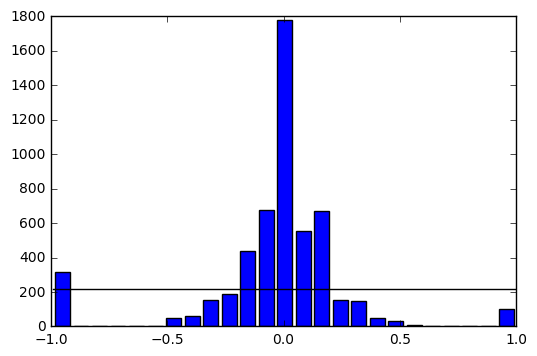

In [28]:
# print a histogram to see which steering angle ranges are most overrepresented
a_angles = a[:,3].astype(np.float)
num_bins = 25
avg_samples_per_bin = len(a)/num_bins
hist, bins = np.histogram(a_angles, num_bins)
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(a_angles), np.max(a_angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

hist = np.concatenate((hist, [1]))  # because no of bins are 26 (0 to 25), but no of hist were 25.(see print(bins, hist) below)
print(bins, hist)

In [29]:
#http://stackoverflow.com/questions/14947909/python-checking-to-which-bin-a-value-belongs/14947961
# Which angle belongs to which bin......
my_list = a_angles  # list of angles
digitized = np.digitize(my_list,bins)  # for list of angles
x = 510
print(my_list[x], digitized[x], bins[digitized[x]], hist[digitized[x]], bins[12], hist[12], avg_samples_per_bin * 0.5)

digitized_single = np.digitize(1.0,bins)-1   # for single angle
digitized_single
print(digitized_single, bins[digitized_single], hist[digitized_single])

-0.02177976 13 0.044647792 555 -0.034964892 1781 107.82
25 1.0 1


In [30]:
#car_images = []
#steering_angles = []
i=0

def process_image(image):
    
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[math.floor(shape[0]/4):shape[0]-25, 0:shape[1]]
    image = cv2.resize(image, (64, 64))
    
    #image2 = np.zeros(image.shape, dtype='u1')
    #image2 = brightness_process_image(image, image2)
    
    return image

(64, 64, 3) (64, 10, 3)


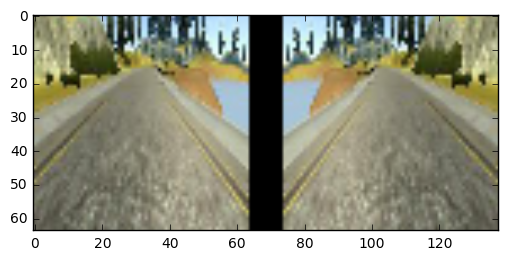

In [31]:
#Sample processing on first image in csv file
path = 'data/data/' # fill in the path to your training IMG directory

divider = np.asarray(np.zeros((64,10,3), dtype='u1'))

#img_center1 = process_image(np.asarray(Image.open(path+csvlines[550][0:38]))) #line[x][0:38], x is row number, [0:38] is characters of first coulmn of that row..
img_center1 = process_image(np.asarray(Image.open(path+samples[250][0])))  #line[x][1], x is row number, [0] is 0th coulmn of that row..
print(img_center1.shape, divider.shape)
img_center1_flipped = np.fliplr(img_center1)
res1 = np.hstack((img_center1, divider, img_center1_flipped))
plt.imshow(res1)


In [32]:
threshold = avg_samples_per_bin * 0.5


def Augmentation(row, car_images, steering_angles):
    steering_center = float(row[3])
    digitized_center = np.digitize(steering_center,bins)-1   #bin number for steering_center angle for this row
    
    # create adjusted steering measurements for the side camera images
    correction = 0.20     # this is a parameter to tune
    steering_left = steering_center + correction
    steering_right = steering_center - correction
    
    digitized_left = np.digitize(steering_left,bins)-1    #bin number for steering_left angle for this row
    digitized_right = np.digitize(steering_right,bins)-1   #bin number for steering_right angle for this row
    
    select_prob = np.random.random()
    
    # read in images from center, left and right cameras
    path = 'data/data/' # fill in the path to your training IMG directory
    
    camera = np.random.choice(['center', 'left', 'right'], p=[0.2,0.4,0.4])
    
    # It balances histogram, if image is in the bin having no of images greater than threshold ....(see above 2 cells)
    #1./(hist[digitized_center]/threshold) is equivalent to  threshold/hist[digitized_center] (i.e 100/500 = 0.2 = keep_probs)
    if hist[digitized_center] > threshold:   #hist[digitized_center] will give no of images in that bin
        keep_probs_center = 1./(hist[digitized_center]/threshold)
    else:
        keep_probs_center = 1
    if select_prob > (1-keep_probs_center) and camera == "center" :
        img_center =  process_image(np.asarray(Image.open(path+row[0])))
        img_center_flipped = np.fliplr(img_center)
        car_images.append(img_center)
        car_images.append(img_center_flipped)
        steering_angles.append(steering_center)
        steering_angles.append(-steering_center)
        
    if hist[digitized_left] > threshold:
        keep_probs_left = 1./(hist[digitized_left]/threshold)
    else:
        keep_probs_left = 1
    if select_prob > (1-keep_probs_left) and camera == "left" and steering_left<0.99::
        img_left =  process_image(np.asarray(Image.open(path+row[1])))
        img_left_flipped = np.fliplr(img_left)
        car_images.append(img_left)
        car_images.append(img_left_flipped)
        steering_angles.append(steering_left)
        steering_angles.append(-steering_left)
        
    if hist[digitized_right] > threshold:
        keep_probs_right = 1./(hist[digitized_right]/threshold)
    else:
        keep_probs_right = 1
    if select_prob > (1-keep_probs_right) and camera == "right" and steering_right>-0.99:
        img_right =  process_image(np.asarray(Image.open(path + row[2])))
        img_right_flipped = np.fliplr(img_right)
        car_images.append(img_right)
        car_images.append(img_right_flipped)
        steering_angles.append(steering_right)
        steering_angles.append(-steering_right)

In [33]:
def generator(samples, batch_size=64):
    num_samples = int(len(samples)/3)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            car_images = []
            steering_angles = []

            for row in batch_samples:
                Augmentation(row, car_images, steering_angles)

            # trim image to only see section with road
            X_train = np.array(car_images)
            y_train = np.array(steering_angles)
            #print(X_train.shape, y_train.shape)
            yield sklearn.utils.shuffle(X_train, y_train)

In [34]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=64)
validation_generator = generator(validation_samples, batch_size=64)

In [35]:
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(64,64,3)))
# layer 1 output shape is 32x32x32
model.add(Convolution2D(32, 5, 5, input_shape=(64, 64, 3), subsample=(2, 2), border_mode="same"))
model.add(ELU())
# layer 2 output shape is 15x15x16
model.add(Convolution2D(16, 3, 3, subsample=(1, 1), border_mode="valid"))
model.add(ELU())
model.add(Dropout(.4))
model.add(MaxPooling2D((2, 2), border_mode='valid'))
# layer 3 output shape is 12x12x16
model.add(Convolution2D(16, 3, 3, subsample=(1, 1), border_mode="valid"))
model.add(ELU())
model.add(Dropout(.4))
# Flatten the output
model.add(Flatten())
# layer 4
model.add(Dense(1024))
model.add(Dropout(.3))
model.add(ELU())
# layer 5
model.add(Dense(512))
model.add(ELU())
# Finally a single output, since this is a regression problem
model.add(Dense(1))

In [36]:
model.compile(loss='mse', optimizer='adam')
#model.fit(X_train, y_train,validation_split=0.2, shuffle=True, nb_epoch=7)
model.fit_generator(train_generator, samples_per_epoch= \
            len(train_samples)*2, validation_data=validation_generator, \
            nb_val_samples=len(validation_samples)*2, nb_epoch=15)         #https://keras.io/models/sequential/#fit_generator

model.save('model_test.h5')

Epoch 1/15
8540/8624 [============================>.] - ETA: 0s - loss: 0.6009

/home/carnd/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


8714/8624 [==============================] - 9s - loss: 0.5919 - val_loss: 0.1455
Epoch 2/15
8750/8624 [==============================] - 7s - loss: 0.1252 - val_loss: 0.1443
Epoch 3/15
8712/8624 [==============================] - 7s - loss: 0.1051 - val_loss: 0.1281
Epoch 4/15
8736/8624 [==============================] - 7s - loss: 0.1051 - val_loss: 0.1326
Epoch 5/15
8674/8624 [==============================] - 7s - loss: 0.0970 - val_loss: 0.1244
Epoch 6/15
8624/8624 [==============================] - 7s - loss: 0.0946 - val_loss: 0.1334
Epoch 7/15
8708/8624 [==============================] - 7s - loss: 0.0946 - val_loss: 0.1230
Epoch 8/15
8638/8624 [==============================] - 7s - loss: 0.0896 - val_loss: 0.1160
Epoch 9/15
8736/8624 [==============================] - 7s - loss: 0.0827 - val_loss: 0.1136
Epoch 10/15
8764/8624 [==============================] - 7s - loss: 0.0800 - val_loss: 0.1171
Epoch 11/15
8680/8624 [==============================] - 7s - loss: 0.0762 - val